# Q03

This Jupyter notebook should answer the following Question:

***How do patient movement patterns relate to the occurrence and severity of falls across different clinical departments and fall risk categories?***

In [43]:
import pandas as pd 
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import math

# Import helper functions
import q2_helper  as helper


pd.set_option('max_colwidth', None)


In [44]:
# colors for graphs
color_01 = '#1A3F6E'
color_02 = '#105067'
color_03 = '#56A6D3'   
color_03_01 = '#02A5F5' 
color_04 = '#578494'

color_dark = '#0A1C3E'
color_contrast1 = '#E0586C'
color_contrast2 = '#F25E4D'
color_contrast3 = '#00E45C'


# Filters and graph Settings:

In [45]:
topThreeDep = pd.read_pickle("data/out/top_three_dep.pkl")

In [46]:
topThreeDep['department']

5            Neurology
8       Intensive Care
10    Gastroenterology
Name: department, dtype: object

In [47]:
# Configurations: Adjust these settings as needed for your analysis

# Department of Interest
department_of_interest = 'Geriatrics'  # Specify the department of interest for synchronization of movements

# Fall Settings
fall_in_dep = True  # Set to True to include falls in the department of interest, False otherwise


# Scope of the Analysis
dep_scope = True  # Set to True to consider only movements within the department of interest, False otherwise
movements_before = 2  # Number of movements to consider before the point of interest
movements_after = 0   # Number of movements to consider after the point of interest
# this never counts the other falls, but only the movements between the falls

# Filters (apply only if fall_in_dep is True)

# Injury Grade Filter
injury_grade_filter = False  # Set to True to filter falls by severity in the department of interest

# Severity of Falls (Used only if injury_grade_filter is True)
selected_injury_grade = 3  # Severity level of falls to include in the analysis
# Options: 'keine'=0, 'gering'=1, 'mäßig'=2, 'schwer'=3

# Threshold for percentage in path
threshold_falls = False  # set true if you want to filter out all paths that were taken less than the threshold

# Threshold for percentage in path (Used only if threshold_falls is True)
percentage_threshold = 2  # Threshold for percentage of falls in the department of interest

only_first = False  # set to True if you only want to consider the first fall in the department of interest

#------------------------------------------------------------
# Generate Point of Interest (Do not change)
#------------------------------------------------------------

point_of_interest = '#FALL_' + department_of_interest + '#' if fall_in_dep else department_of_interest

# Imports

# DF Preparations

In [48]:
nBew = pd.read_pickle("data/src_pkl/nBew.pkl")
fallD = pd.read_pickle("data/src_pkl/sturzD.pkl")

## generate movements table

In [49]:
# get all patients with fall incident
fallers = list(fallD['c_pseudonym'].unique())

# Filter the DataFrame to include only fallers
fallers_data = nBew[nBew['c_pseudonym'].isin(fallers)]


# Step 1: Sort by 'c_pseudonym' and 'from_time'
fallers_data_sorted = fallers_data.sort_values('c_lfdnr')

# Step 2: Group by 'c_pseudonym' and aggregate using a custom function
movements = fallers_data_sorted.groupby('c_pseudonym').agg({
    'c_orgfa': lambda x: list(x),
    'from_time': lambda x: list(x),
    'till_time': lambda x: list(x)
}).reset_index()

In [50]:

# Rename columns to match your expected output
movements.columns = ["c_pseudonym", "movement", "from_time", "till_time"]

In [51]:
movements['number_of_movements'] = movements['movement'].apply(len)

In [52]:
# add first department to df
movements['fist_dep'] = movements['movement'].apply(lambda x: x[0])

## gnereate falls_per case

contains the falls and times of falls per case

In [53]:
# adjust Grad der verletzung: map 'keine' to 0, 'gering' to 1, 'mäßig' to 2, 'schwer' to 3
fallD['Grad der Verletzung'] = fallD['Grad der Verletzung'].map({'keine': 0, 'gering': 1, 'mäßig': 2, 'schwer': 3})


In [54]:
fallD = fallD.sort_values('Sturz_datetime', ascending=True)

falls_per_case = fallD.groupby('c_pseudonym').agg({
    'Fachliche Zuweisung': list,
    'Sturz_datetime': list,
    'Grad der Verletzung': list
}).reset_index()

In [55]:
falls_per_case['number_of_falls'] = falls_per_case['Fachliche Zuweisung'].apply(len)
falls_per_case = falls_per_case.sort_values('number_of_falls', ascending=False)

##  Build Movement_falls

contains all movements and falls with times per case

In [56]:
movements_falls = pd.merge(movements, falls_per_case, on='c_pseudonym')
movements_falls = movements_falls.rename(columns={'Fachliche Zuweisung':'fall_department','Sturz_datetime':'fall_time','Grad der Verletzung':'injury_grade'})

### ajustment of movements_falls

In [57]:
#deletes all movements that are to the same department (e.g. from department a to department a)
movements_falls = movements_falls.apply(helper.neighbours_checker,axis=1)


In [58]:
# gernerates column with index of fall in movements list ( all x is at the yth department of the index in the movements list)
movements_falls['index_of_fall'] = movements_falls.apply(helper.find_index_of_fall,axis=1)


In [59]:
# deletes all falls that are at the same index as the prior fall ( e.g. fall 1 and fall 2 are at the same department without any movement in between)
movements_falls = movements_falls.apply(helper.condense_falls,axis=1)

In [60]:
# count number of falls that occure in a department where the patient never was (according to the movement data)
print('number of falls of patients never being on that station: ',(movements_falls['index_of_fall'] == 'NaN').sum())


number of falls of patients never being on that station:  133


In [61]:
movements_falls_nan = movements_falls[movements_falls['index_of_fall'] == 'NaN']

In [62]:
# delete all cases in which at least one fall occured in a department where the patient never was (according to the movement data)
movements_falls = movements_falls[movements_falls['index_of_fall'] != 'NaN']

In [63]:
movements_falls['dep_and_falls'] = movements_falls.apply(helper.fall_integrator,axis=1)

## apply filters for graph

In [64]:
# filter column 'dep_and_falls' of movements_falls for the point of interest
movements_falls = movements_falls[movements_falls['dep_and_falls'].apply(lambda x: point_of_interest in x)]


In [65]:
# todo severity filter
if injury_grade_filter:
    if not fall_in_dep:
        print('nothing done, only works when looking at falls,')
        raise Exception("POI is not a fall department, please set injury_grade_filter = False ")
    else: 
        movements_falls['injury_grades'] = movements_falls.apply(lambda row: helper.find_fall_severities(row,department_of_interest),axis=1)

        bef = movements_falls.shape[0]

        movements_falls = movements_falls[movements_falls['injury_grades'].apply(lambda x: selected_injury_grade in x)]

        #movements_falls = movements_falls[selected_injury_grade in movements_falls["injury_grades"]]
        print (bef- movements_falls.shape[0], ' falls eliminated due to wrong level, ', movements_falls.shape[0], 'falls left')


In [66]:
movements_falls['dep_and_falls'].to_pickle("data/test/dep_and_falls.pkl")

In [ ]:
# filter for scope of analysis
if dep_scope:
    movements_falls['dep_and_falls_scope'] = movements_falls.apply(lambda row: helper.fall_scope_filter(row['dep_and_falls'],point_of_interest,movements_before,movements_after),axis=1)
else:
    movements_falls['dep_and_falls_scope'] = movements_falls['dep_and_falls']

In [68]:
if only_first:
    movements_falls['dep_and_falls_scope'] = movements_falls.apply(lambda row: helper.only_first_falls(row['dep_and_falls_scope'],point_of_interest),axis=1)

In [69]:
# add start and end element to each list in 'dep_and_falls_scope'
movements_falls['dep_and_falls_scope'] = movements_falls['dep_and_falls_scope'].apply(lambda x: ['*START*'] + x + ['*END*'])

In [70]:
movements_falls2  = movements_falls[movements_falls['movement'].apply(lambda x: len(x) == 3)]

In [72]:
movements_falls['graph_tuples'] = movements_falls['dep_and_falls_scope'].apply(helper.tuple_builder)

In [73]:
graph_tuples = movements_falls['graph_tuples'].explode().dropna()

In [74]:
filtered_tuples = [tup for tup in graph_tuples if '*START*' in tup]

In [75]:
graph_tuples = graph_tuples.value_counts().reset_index()
# filter out all paths that were taken less than the threshold
if threshold_falls:
    l = len(graph_tuples)
    #graph_tuples = graph_tuples[graph_tuples['count']>=len(filtered_tuples)*percentage_threshold]
    graph_tuples = graph_tuples[graph_tuples['count']>=percentage_threshold]
    print(l- len(graph_tuples)," paths deleded due to thresholod filter. ", len(graph_tuples)," paths left")
else:
    print('No Threshold set, all paths are included')
# rename columns
graph_tuples = graph_tuples.rename(columns={'graph_tuples':'tuple'})

No Threshold set, all paths are included


In [76]:

# Function to update each tuple with count
def update_tuple(row):
    return row['tuple'] + (row['count'],)

# Apply the function to each row
graph_tuples['tuple'] = graph_tuples.apply(lambda row: update_tuple(row), axis=1)


In [77]:
# save graph_tuples to pkl
graph_tuples.to_pickle('data/out/graph_tuples.pkl')

# Plotting

<span style="color:orange"> 

## Note, the following graph is static, if you wish to have a dynamic graph, please run the 'Q_02_graph_mover.py' file
</span>

In [78]:
# generate directed graph 
G = nx.DiGraph()

# add nodes and edges
edges = graph_tuples['tuple']
G.add_weighted_edges_from(edges)

# define special nodes
start_nodes = ['*START*']
end_nodes = ['*END*']
orange_nodes = [node for node in G.nodes() if node.startswith('#')]
grey_nodes = [node for node in G.nodes() if node.startswith('(')]

In [79]:
# add graph layout

#pos = nx.circular_layout(G) # good
#pos = nx.shell_layout(G) # good
pos = nx.nx_agraph.graphviz_layout(G)#prog='neato')  
# pos = nx.spring_layout(G, k=0.15, iterations=20) 

# Manually set positions for *START* and *END* nodes
# pos['*START*'] = (0, 0.5)  # Example position for *START*
# pos['*END*'] = (, 0.5)  # Example position for *END* (x_max should be computed as maximum x coordinate)



In [80]:
# add edge weights and labels

# Calculate edge widths based on weights and normalize to range [1, 10]
edge_weights = [d['weight'] for u, v, d in G.edges(data=True)]
min_weight = min(edge_weights)
max_weight = max(edge_weights)
#edge_widths = [1 + (9 * (d['weight'] - min_weight) / (max_weight - min_weight)) for u, v, d in G.edges(data=True)]

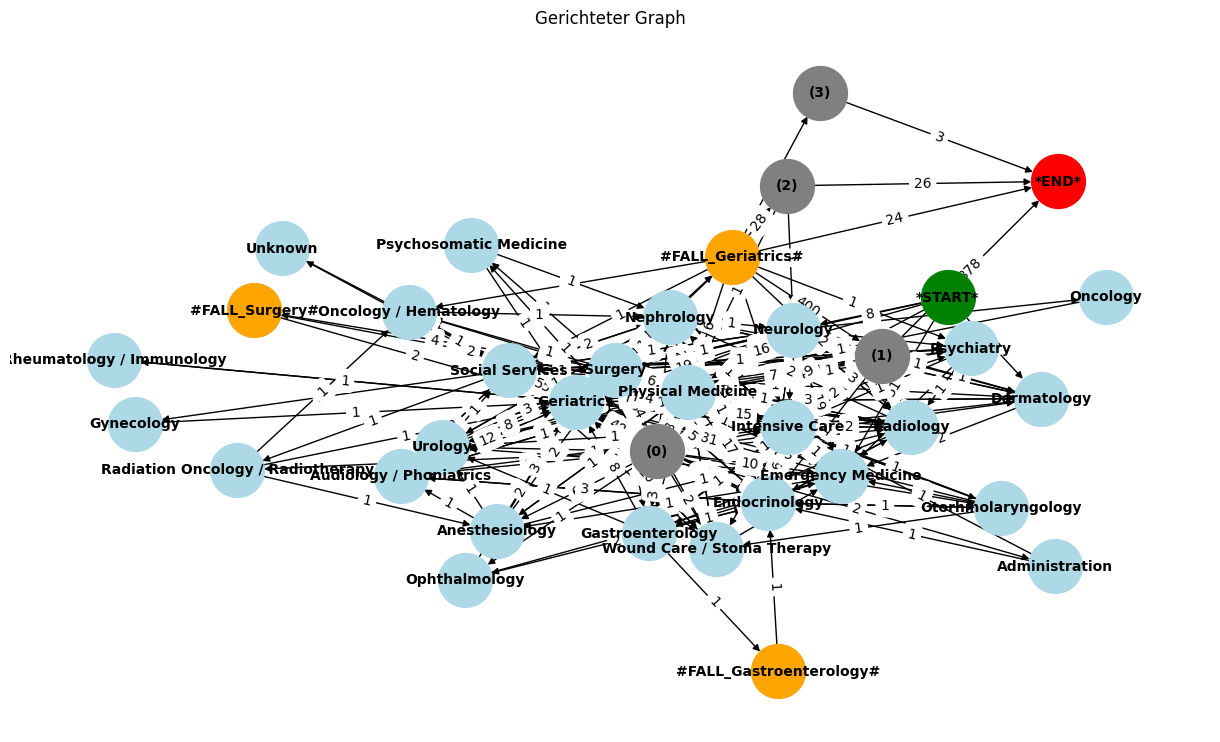

In [81]:

# plot graph
plt.figure(figsize=(12, 7))  # Set the size of the plot
nx.draw(G, pos, with_labels=True, node_size=1500, node_color='lightblue', font_size=10, font_weight='bold', arrows=True)
#nx.draw(G, pos, with_labels=True, node_size=1500, node_color='lightblue', font_size=10, font_weight='bold', arrows=True, width=edge_widths, connectionstyle='arc3,rad=0.2')



# with labeled edges
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black')


# Hebe Start- und Endknoten hervor
nx.draw_networkx_nodes(G, pos, nodelist=start_nodes, node_color='green', node_size=1500)
nx.draw_networkx_nodes(G, pos, nodelist=end_nodes, node_color='red', node_size=1500)

# Färbe Knoten, die mit '#' beginnen, orange
nx.draw_networkx_nodes(G, pos, nodelist=orange_nodes, node_color='orange', node_size=1500)

nx.draw_networkx_nodes(G, pos, nodelist=grey_nodes, node_color='grey', node_size=1500)


# Zeige den Graphen
plt.title('Gerichteter Graph')
plt.show()


In [82]:
st = graph_tuples.copy()
st[["source","target","count2"]] = pd.DataFrame(st['tuple'].tolist(), index=st.index)
st = st.drop(columns=['tuple','count2'])

In [83]:
config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'custom_image',
    'height': 500,
    'width': 1500,
    'scale':6 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

In [84]:
# Copy the DataFrame
st_diag = st.copy()

# Create a list of unique labels
labels = list(pd.unique(st_diag[['source', 'target']].values.ravel('K')))

# Create a mapping from label to index
label_to_index = {label: i for i, label in enumerate(labels)}

# Map source and target strings to their corresponding indices
st_diag['source'] = st_diag['source'].map(label_to_index)
st_diag['target'] = st_diag['target'].map(label_to_index)



# Create a color mapping for the nodes
node_colors = [
    color_dark if '*START*' in label else 
    color_contrast1 if '#' in label else 
    color_dark if '*END*' in label else 
    'lightgrey' if '(' in label else 
    color_03 
    for label in labels
]

# Function to convert color to RGBA with opacity
def color_to_rgba(color, opacity):
    import matplotlib.colors as mcolors
    if color in mcolors.CSS4_COLORS:
        rgba = mcolors.to_rgba(mcolors.CSS4_COLORS[color])
    else:
        rgba = mcolors.to_rgba(color)
    return f"rgba({int(rgba[0]*255)}, {int(rgba[1]*255)}, {int(rgba[2]*255)}, {opacity})"

# Create a mapping from node index to color with 30% opacity
node_index_to_color_rgba = {index: color_to_rgba(color, 0.6) for index, color in enumerate(node_colors)}

# Map link colors based on the source node
link_colors = st_diag['source'].map(node_index_to_color_rgba)

# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=labels,
        color=node_colors,
        align='left'
    ),
    link=dict(
        arrowlen=20,
        source=st_diag['source'],
        target=st_diag['target'],
        value=st_diag['count'],
        color=link_colors
    )
)])

print("Movements of department " + department_of_interest + " with fall related injury level: severe")

fig.update_layout(font_size=10)

fig.show(config=config)


Movements of department Geriatrics with fall related injury level: severe
